## Project Description:

#### Goal:

In this hands-on project, the goal is to build a face detection model which includes building a face detector to locate the position of a face in an image.

#### Dataset: WIDER Face Dataset:


WIDER FACE dataset is a face detection benchmark dataset, of which images are selected
from the publicly available WIDER dataset.

This data has 32,203 images and 393,703 faces are labelled with a high degree of variability in
scale, pose and occlusion as depicted in the sample images.

In this project, we are using 500 images and 1100 faces for ease of computation

#### In this problem  "Transfer Learning" of an Object Detector model is used to detect any object according to the problem in hand.

Here, We are particularly interested in detecting faces in a given image.

#### To use the model first, we need to import the model and its supporting files for the model to function. 

We see the below steps to import the model.

---------------------------------------------------------------------------------------------
###### Step 1: Import MobileNet model given in file `mn_model.py`

In [0]:
# Import MobileNet model given in file `mn_model.py`

from mn_model import mn_model

##### Step 2:  Import Necessary Libraries

In [0]:
#### Import the BatchGenerator and SSDLoss functions as well, used in MobileNet model

from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

In [0]:

import warnings
warnings.filterwarnings("ignore")

from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.callbacks import Callback
from keras import backend as K 
from keras.models import load_model
from math import ceil 
import numpy as np 
from termcolor import colored

from mn_model import mn_model
from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

# training parameters
from keras import backend as K
import scipy.misc as sm


##### Step 3: Set the parameters for the model

###### We need to customize the model parameters according to our problem as given below.

###### Set n_classes (no.of classes) = 2, as we are interested in only face detection. 
###### `Face` will be one class and everything else comes under other class (we can call it as `background`)

###### Set class_names = ["background", "face"]

In [0]:
img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

det_model_path = "./"

##### Step 4: Now, we have imported the model and its dependencies. The next thing is to import the dataset for the model to train on. For this, we are using the WIDER FACE dataset. 

###### To make the dataset available follow the steps given below.


1. Create a folder in your google drive for this project. 

2. Download the train and test dataset files given in .zip format into your drive folder you created for the project in step-1.

3. Set the project path variable according to the folders you created to use for this project in your google drive. 

      

4. Now, as we mount the drive the images will be available to use for training and testing but in zip format.

5. So, lets extract the images from the zipfiles by using the code given of zipfile module.







In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_path = "/content/drive/My Drive/DLCP/"

In [0]:
train_images_path = project_path + 'WIDER_train.zip'
test_images_path = project_path + 'WIDER_val.zip'

In [0]:
import zipfile
archive = zipfile.ZipFile(train_images_path, 'r')
archive.extractall()

In [0]:
archive = zipfile.ZipFile(test_images_path, 'r')
archive.extractall()

##### Step 5: Now, the images are available. The next thing we need is to get the labels for these images, so that we can use this information while training for detecting faces with the given model using transfer learning. 

###### Follow the below steps to get those labels available.


Load the  '' `wider_train_small.npy`'' file given to check the information given about the dataset. In this file you can see the information about each image in the dataset in a list with following elemets:
      

        1.   Image filename (str)
        2.   Image filename (str)
        3.   Image size (list) [height, width]
        4.   List of bounding box co-ordinates and Class label (list) [[a,b,c,d], Class label, ...]
        
        where,
        a,b,c,d are the four co-ordinates of the bounding box
        Class label is the position of object as mentioned in `class_names` list above.

In [0]:
data = np.load('./wider_train_small.npy').item()

In [23]:
### Printed first element to check the above given information.

for key in data:
  print key
  print data[key]
  break

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg
['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]


 As we can see from the above output all the information mentioned above is there for all the images.

### Now, load the files `wider_trian.npy` and `wider_val.npy`

In [0]:
train_data = 'wider_train_small.npy'
test_data = 'wider_val_small.npy'

x = np.load(train_data)

##### Step 6: Defining Model
Now, call the imported model with the given parameters and freeze all the layers in the model with names not having ''`detection`'' word as prefix.

As we are not training the model from scratch, we are freezing all the above layers in the model having only last few layers while training to update their weights according to the problem in hand. This is called as **Transfer Learning**.

In [38]:
# build the keras model
# this model is not retrained, we are doing it from scratch 

K.clear_session()
model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

#model.summary()
print ("Freezing classification layers")
#Freeze layers
for layer_key in model_layer:
  if('detection'  not in layer_key): #prefix detection to freeze layers which does not have detection
    model_layer[layer_key].trainable = False
print (colored("classification layers freezed", 'green'))

====> Model Specific data
====> Height, Width, Channels : 512 512 3
Freezing classification layers
classification layers freezed


 After making the model ready for transfer learning, load the weights of the model given in file ''`mobilenet_1_0_224_tf.h5`''

In [40]:
print ("loading classification weights")
classification_model = 'mobilenet_1_0_224_tf.h5'
model.load_weights(classification_model,  by_name= True)

loading classification weights


#### Using the functions given in the model, we are trying to divide the dataset into train and validation samples. Run the below code.

In [47]:
batch_size = 32
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

train_dataset = BatchGenerator(images_path=train_data, 
                include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==>TRAINING DATA")
print ("==> Parsing XML files ...")

train_dataset.parse_xml(
                  annotations_path=train_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)
print("==>Parsing XML Finished.")

print ("==>Generate training batches...")
train_generator = train_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=True,
                 brightness=(0.5,2,0.5),
                 flip=0.5,
                 translate=((0, 20), (0, 30), 0.5),
                 scale=(0.75, 1.2, 0.5),
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False,
                 resize=(img_height, img_width),
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print ("==>Training batch generation complete")

n_train_samples = train_dataset.get_n_samples()

print ("==>Total number of training samples = {}".format(n_train_samples))

# Now repeat above steps for validation data 

print ("==>VALIDATION")

val_dataset = BatchGenerator(images_path=test_data, include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==> Parsing XML files ...")


val_dataset.parse_xml(
                  annotations_path=test_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)


print("==>Parsing XML Finished.")


print ("==>Generate training batches...")
val_generator = val_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False, 
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)


print ("==>Training batch generation complete")

n_val_samples = val_dataset.get_n_samples()

print ("==>Total number of validation samples = {}".format(n_val_samples))

==>TRAINING DATA
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of training samples = 128
==>VALIDATION
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of validation samples = 60


##### Step 7: Defining Tuning Parameters

Now, lets setup things for training by initilaizing required variables like learning rate, epochs, optimizer and loss function(SSDLoss) to compile the model

In [0]:
# setting up training 

batch_size = 16
num_epochs = 10

#Learning rate
base_lr = 0.002

# Optimizer
adam = Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay = 0.0)

# Loss
ssd_loss = SSDLoss(neg_pos_ratio=2, n_neg_min=0, alpha=1.0, beta = 1.0)

# Compile
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

##### Step8: Training Model

Lets add early stopping and model checkpoint layers on validation loss with some patience values and using fit_generator function to train the model on data generated batch-by-batch by a Python generator, `train_generator` object as generator.


We are using checkpoint to save the best model based on validation accuracy.

In [57]:
# def scheduler(epoch):
#   if epoch%10==0 and epoch!=0:
#   #if epoch !=0 or epp:
#     lr = K.get_value(model.optimizer.lr)
#     K.set_value(model.optimizer.lr, lr*.95)
#     print("lr changed to {}".format(lr*.95))
#   else: 
#     print("lr remains {}".format(K.get_value(model.optimizer.lr)))

#   return K.get_value(model.optimizer.lr)

#lr_schedule = LearningRateScheduler(scheduler)

# plateau = ReduceLROnPlateau(monitor='val_loss', factor = 0.3, patience =4, epsilon=0.001, cooldown=0)
#tensorboard = TensorBoard(log_dir='./logs/trial1/', histogram_freq=1, batch_size=16, write_graph=True, write_grads=True, 
#                           write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=100)
model_checkpoint =  ModelCheckpoint(det_model_path + 'ssd_mobilenet_face_epoch_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

print ("training starting...")
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size)*2,
                              epochs = num_epochs,
                              callbacks = [model_checkpoint, early_stopping],                      
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

model.save_weights(det_model_path + 'ssd_mobilenet_weights_epoch_{}.h5'.format(num_epochs))

print ("model and weight files saved at : " + det_model_path)


training starting...
Epoch 1/10
lr remains 0.00200000009499
16/16 [==============================] - 18s 1s/step - loss: 0.4070 - val_loss: 0.4664

Epoch 00001: val_loss improved from inf to 0.46640, saving model to ./ssd_mobilenet_face_epoch_01_loss0.4664.h5
Epoch 2/10
lr remains 0.00200000009499
16/16 [==============================] - 16s 1s/step - loss: 0.4215 - val_loss: 0.4522

Epoch 00002: val_loss improved from 0.46640 to 0.45221, saving model to ./ssd_mobilenet_face_epoch_02_loss0.4522.h5
Epoch 3/10
lr remains 0.00200000009499
16/16 [==============================] - 17s 1s/step - loss: 0.4024 - val_loss: 0.4237

Epoch 00003: val_loss improved from 0.45221 to 0.42375, saving model to ./ssd_mobilenet_face_epoch_03_loss0.4237.h5
Epoch 4/10
lr remains 0.00200000009499
16/16 [==============================] - 16s 1s/step - loss: 0.4152 - val_loss: 0.4207

Epoch 00004: val_loss improved from 0.42375 to 0.42073, saving model to ./ssd_mobilenet_face_epoch_04_loss0.4207.h5
Epoch 5/10


 Load the best saved model from above step and check predictions for test data using test_generator object to generate batches.

In [58]:
model_path = './'
model_name = 'ssd_mobilenet_face_epoch_25_loss0.0916.h5'

model.load_weights(model_path + model_name,  by_name= True)

print (colored('weights %s loaded' % (model_path + model_name), 'green'))

weights ./ssd_mobilenet_face_epoch_25_loss0.0916.h5 loaded


##### Step 9: Plotting Bounding Box

Use the below function to plot the boundingbox in the test image to show the predictions.

In [0]:
def save_bb(path, filename, results, prediction=True):
  
  # print filename

  img = image.load_img(filename, target_size=(img_height, img_width))
  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, 25)).tolist()
  color_code = min(len(results), 16)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1]
      det_xmax = result[2]
      det_ymin = result[3]
      det_ymax = result[4]

    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))
    label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}'.format(score)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[color_code]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.2})

  # y
  currentAxis.axes.get_yaxis().set_visible(False)
  # x
  currentAxis.axes.get_xaxis().set_visible(False)
  plt.savefig(path + filename, bbox_inches='tight')

  print ('saved' , path + filename)

  plt.clf()


In [0]:
!mkdir output_test

In [61]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

test_size = 16
test_generator = val_dataset.generate(
                 batch_size=test_size,
                 train=False,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print (colored("done.", "green"))

print (colored("now predicting...", "yellow"))

_CONF = 0.60 
_IOU = 0.15

for i in range(test_size):
  X, y, filenames = next(test_generator)

  y_pred = model.predict(X)


  y_pred_decoded = decode_y2(y_pred,
                             confidence_thresh=_CONF,
                            iou_threshold=_IOU,
                            top_k='all',
                            input_coords=coords,
                            normalize_coords=normalize_coords,
                            img_height=img_height,
                            img_width=img_width)


  np.set_printoptions(suppress=True)

  save_bb("./output_test/", filenames[i], y_pred_decoded[i])
  save_bb("./output_test/", filenames[i], y[i], prediction=False)


done.
now predicting...
total number of bbs: 0
('saved', './output_test/47_Matador_Bullfighter_matadorbullfighting_47_731.jpg')
total number of bbs: 4
('saved', './output_test/47_Matador_Bullfighter_matadorbullfighting_47_731_gt.jpg')
total number of bbs: 1
('saved', './output_test/33_Running_Running_33_209.jpg')
total number of bbs: 1
('saved', './output_test/33_Running_Running_33_209_gt.jpg')
total number of bbs: 2
('saved', './output_test/4_Dancing_Dancing_4_514.jpg')
total number of bbs: 2
('saved', './output_test/4_Dancing_Dancing_4_514_gt.jpg')
total number of bbs: 6
('saved', './output_test/21_Festival_Festival_21_395.jpg')
total number of bbs: 9
('saved', './output_test/21_Festival_Festival_21_395_gt.jpg')
total number of bbs: 3
('saved', './output_test/17_Ceremony_Ceremony_17_1048.jpg')
total number of bbs: 4
('saved', './output_test/17_Ceremony_Ceremony_17_1048_gt.jpg')
total number of bbs: 1
('saved', './output_test/57_Angler_peoplefishing_57_153.jpg')
total number of bbs: 1

IndexError: ignored

##### Step 10:  Visualize a test image to check predictions

In [0]:
import cv2

In [0]:
cv2.imshow('output_test/21_Festival_Festival_21_395.jpg')

Populating the interactive namespace from numpy and matplotlib


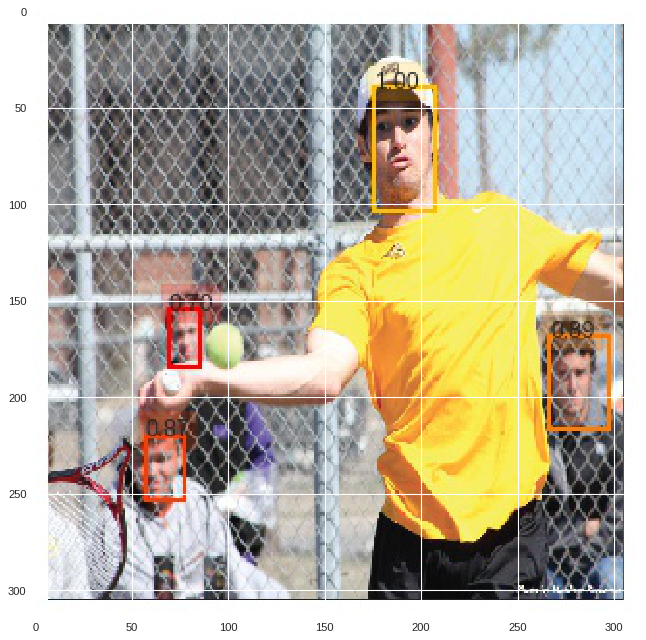

In [81]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('output_test/38_Tennis_Tennis_38_501.jpg')
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(img)

plt.show()